# LSTM RNN

This is an implementation of the LSTM RNN from Bowman et al. (https://nlp.stanford.edu/pubs/snli_paper.pdf) for text classification on the SST dataset and Textual entailment on the SNLI dataset. 

## Initialzation

Required packages and helper functions.

In [1]:
!pip install numpy
!pip install torchtext
!pip install torch
!pip install sklearn
!pip install bokeh
!pip install matplotlib

    100% |████████████████████████████████| 71kB 2.8MB/s 
    100% |████████████████████████████████| 591.8MB 18kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61a72000 @  0x7f3d188ea2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
import numpy as np

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
from torch.nn.functional import softmax, relu, tanh
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.nn.utils.rnn import pad_sequence as pad

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook, show, push_notebook

output_notebook()

Loading BokehJS ...

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [0]:
def accuracy(ys, ts):
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    return torch.mean(correct_prediction.float())

## SST
### Data creation

In [0]:
TEXT = data.Field(sequential=True, include_lengths = True)
LABEL = data.Field(sequential=False)

train_set, validation_set, test_set = datasets.SST.splits(TEXT,
                                                          LABEL,
                                                          fine_grained=False,
                                                          train_subtrees=True,
                                                          filter_pred=lambda ex: ex.label != 'neutral')

In [6]:
# build the vocabulary
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
#TEXT.build_vocab(train_set, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
TEXT.build_vocab(train_set,vectors=GloVe(name='840B',dim='300'))
LABEL.build_vocab(train_set)
# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())

# make iterator for splits
train_iter, val_iter, test_iter = data.Iterator.splits(
    (train_set, validation_set, test_set), batch_size=32, sort_key=lambda x: len(x.text),sort_within_batch=True)
batchsst = next(iter(train_iter))

len(TEXT.vocab) 18003
TEXT.vocab.vectors.size() torch.Size([18003, 300])


### Model framework

In [7]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.4
input_dim = 200
con_dim = 200
hid_size = 500

# build the LSTM model
class LSTMNet(nn.Module):

    def __init__(self):
        super(LSTMNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)

        # Simple RNN LSTM Layer
        self.lstm_input = nn.LSTM(input_size = embedding_dim,
                                  hidden_size = hid_size)
        
        # Linear layer (with tanh activation) for mapping to lower dimensions
        self.input = Linear(in_features = hid_size,
                             out_features = input_dim,
                             bias = True)
        
        # Three stacked linear layers (with tanh activation)
        self.l_1 = Linear(in_features=input_dim,
                           out_features=con_dim,
                           bias = True)
        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias=True)
        self.l_3 = Linear(in_features=con_dim,
                           out_features = con_dim,
                           bias = True)
        self.batchnorm = nn.BatchNorm1d(num_features=con_dim)
        
        
        # Applied dropout
        self.drop = nn.Dropout(p = dropout_rate)
        
        # Putput layer
        self.l_out = Linear(in_features= con_dim,
                            out_features=num_classes,
                            bias=False)
        
        
    def forward(self, x):
        out = {}
        
        x_text = x[0] #Text of input
        x_len = x[1] #Sequence length of input
    
        x_len, idx_sort = np.sort(x_len)[::-1],np.argsort(-x_len)
        x_text = x_text.index_select(1,torch.LongTensor(idx_sort))
    
        # Get embeddings
        x = self.embeddings(x_text) # (batch size, length, embedding dim)
        x = self.drop(x)


        # Packing padded sequences to max_length
        packed_x = pack(x,x_len.copy(), batch_first = False)
        
        # LSTM RNN Layer
        x = self.lstm_input(packed_x)[1][0].squeeze(0)

        
        # Unpacking packed tensors

        xt = x
        
        idx_unsort = np.argsort(idx_sort)
        xt = xt.index_select(0,torch.LongTensor(idx_unsort))
        
        xt = self.drop(xt)
        
        xt = tanh(self.input(xt))
        
        z = xt
        
        # Three stacked tanh layers
        z = tanh(self.l_1(z))     
        z = tanh(self.l_2(z))
        z = tanh(self.l_3(z))
        
        z = self.batchnorm(z)
 
        # Softmax
        out['out'] = softmax(self.l_out(z))
        return out

net = LSTMNet()
print(net)

LSTMNet(
  (embeddings): Embedding(18003, 300)
  (lstm_input): LSTM(300, 500)
  (input): Linear(in_features=500, out_features=200, bias=True)
  (l_1): Linear(in_features=200, out_features=200, bias=True)
  (l_2): Linear(in_features=200, out_features=200, bias=True)
  (l_3): Linear(in_features=200, out_features=200, bias=True)
  (batchnorm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.4)
  (l_out): Linear(in_features=200, out_features=3, bias=False)
)


In [0]:
#{p[0]: p[1].requires_grad for p in net.named_parameters()}


### Training the model

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001,amsgrad=True,weight_decay=0.00001)

#max_iter = 100
eval_every = 1000
log_every = 200
#epochmax = 5


train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while reached_max == False:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.text)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        
            net.train()
    
        output = net(batch.text)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=0.5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1

EPOCH NR: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


valid, it: 0 loss: 1.10 accs: 0.49

train, it: 0 loss: 1.12 accs: 0.25
train, it: 200 loss: 0.79 accs: 0.77
train, it: 400 loss: 0.76 accs: 0.79
train, it: 600 loss: 0.76 accs: 0.79
train, it: 800 loss: 0.77 accs: 0.78
valid, it: 1000 loss: 0.85 accs: 0.71

train, it: 1000 loss: 0.80 accs: 0.75
train, it: 1200 loss: 0.80 accs: 0.75
train, it: 1400 loss: 0.83 accs: 0.72
train, it: 1600 loss: 0.83 accs: 0.73
train, it: 1800 loss: 0.81 accs: 0.75
valid, it: 2000 loss: 0.90 accs: 0.65

train, it: 2000 loss: 0.81 accs: 0.74
train, it: 2200 loss: 0.83 accs: 0.73
train, it: 2400 loss: 0.80 accs: 0.75
train, it: 2600 loss: 0.80 accs: 0.75
train, it: 2800 loss: 0.79 accs: 0.76
valid, it: 3000 loss: 0.90 accs: 0.65

train, it: 3000 loss: 0.78 accs: 0.77
EPOCH NR: 2
valid, it: 0 loss: 0.85 accs: 0.70

train, it: 0 loss: 0.77 accs: 0.78
train, it: 200 loss: 0.75 accs: 0.80
train, it: 400 loss: 0.74 accs: 0.81
train, it: 600 loss: 0.73 accs: 0.82
train, it: 800 loss: 0.72 accs: 0.83
valid, it: 1000

NameError: ignored

In [0]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
        continue
    else:
        train_iter_list[i] = train_iter_list[i-1] + log_every


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
        continue
    else:
        val_iter_list[i] = val_iter_list[i-1] + eval_every

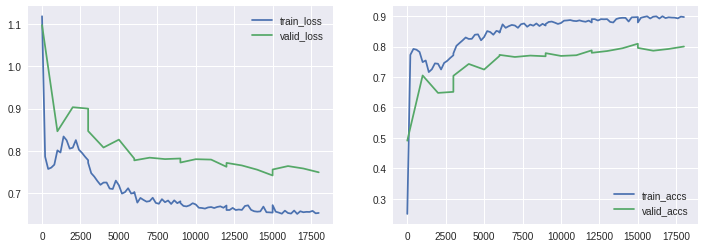

In [11]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()

# SNLI

In [4]:
print("Run test on SNLI...")
TEXT = datasets.nli.ParsedTextField()
LABEL = data.Field(sequential=False)
TREE = datasets.nli.ShiftReduceField()

train, validation, test = datasets.SNLI.splits(TEXT, LABEL,TREE)

print("Fields:", train.fields)
print("Number of examples:\n", len(train))
print("First Example instance:\n", vars(train[0]))

url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
#TEXT.build_vocab(train, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
TEXT.build_vocab(train,vectors=GloVe(name='840B',dim='300'))
LABEL.build_vocab(train)

batchsize = 64

train_iter, val_iter, test_iter = data.Iterator.splits(
    (train, validation, test), batch_size=batchsize, repeat=False)

print("Test iters function")

batch = next(iter(train_iter))
print("Numericalize premises:\n", batch.premise)
print("Numericalize hypotheses:\n", batch.hypothesis)
print("Entailment labels:\n", batch.label)

Run test on SNLI...
downloading snli_1.0.zip


snli_1.0.zip: 100%|██████████| 94.6M/94.6M [00:04<00:00, 20.9MB/s]


extracting


.vector_cache/glove.840B.300d.zip: 0.00B [00:00, ?B/s]

Fields: {'premise': <torchtext.datasets.nli.ParsedTextField object at 0x7ff2fa49de48>, 'premise_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x7ff2fa49dfd0>, 'hypothesis': <torchtext.datasets.nli.ParsedTextField object at 0x7ff2fa49de48>, 'hypothesis_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x7ff2fa49dfd0>, 'label': <torchtext.data.field.Field object at 0x7ff2fa49df98>}
Number of examples:
 549367
First Example instance:
 {'premise': ['A', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.'], 'premise_transitions': ['shift', 'shift', 'reduce', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'shift', 'shift', 'shift', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'reduce', 'reduce', 'shift', 'reduce', 'reduce'], 'hypothesis': ['A', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.'], 'hypothesis_transitions': ['shift', 'shift', 'reduce', 'shift', 'shift', 'shift', 's

.vector_cache/glove.840B.300d.zip: 2.18GB [01:34, 23.1MB/s]                            
100%|█████████▉| 2195556/2196017 [05:33<00:00, 8319.34it/s]

Test iters function
Numericalize premises:
 (tensor([[   4,   61,    4,  ...,    4,   20,   20],
        [ 260,  133,   67,  ..., 1777,   66,   19],
        [   6,  216,   89,  ...,    5,  118,   33],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]]), tensor([10, 14, 17, 19, 13, 19, 13,  9, 18, 18, 10, 11, 10,  9, 17, 16, 16, 16,
        16, 26, 18, 16, 12, 18,  9, 11, 13, 11, 23, 17,  9, 14, 11, 22, 11,  9,
        12, 12, 17, 13,  9, 10, 17,  5, 17, 12,  8, 11, 13, 13, 13, 16, 14,  9,
        16, 16, 10, 10, 10,  8, 16, 15, 16, 12]))
Numericalize hypotheses:
 (tensor([[ 14,  14,  14,  ...,  14,  20,  58],
        [260, 133,  89,  ..., 228, 118,  11],
        [  6, 216,   6,  ...,   6,  11, 152],
        ...,
        [  1, 421,   1,  ...,   1,   1,   1],
        [  1,   2,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]]), tensor([ 8, 16,  6, 

In [5]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.4
input_dim = 100
con_dim = 200


# build the LSTM model
class LSTMNet(nn.Module):

    def __init__(self):
        super(LSTMNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)

        # Simple RNN LSTM Layer
        self.lstm_input = nn.LSTM(input_size = embedding_dim,
                                  hidden_size = embedding_dim,
                                  num_layers = 1,
                                  batch_first = False)
        
        # Linear layer (with tanh activation) for mapping to lower dimensions
        self.input = Linear(in_features = embedding_dim,
                             out_features = input_dim,
                             bias = False)
        
        # Three stacked linear layers (with tanh activation)
        self.l_1 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias = False)
        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias=False)
        self.l_3 = Linear(in_features=con_dim,
                           out_features = con_dim,
                           bias = False)
        
        
        # Applied dropout
        self.drop = nn.Dropout(p = dropout_rate)
        
        # Putput layer
        self.l_out = Linear(in_features=con_dim,
                            out_features=num_classes,
                            bias=False)
        
        
    def forward(self, x, y):
        out = {}
        
        # First input
        # input = (text_tensor, seq_length_tensor)
        x_text, x_len = x
        
        # Sorting tensors
        x_len, idx_sort = np.sort(x_len)[::-1],np.argsort(-x_len)
        x_text = x_text.index_select(1,torch.LongTensor(idx_sort))

        # Get embeddings
        x = self.embeddings(x_text) # (batch size, length, embedding dim)
        
        # Applied dropout
        x = self.drop(x)

        # Packing padded sequences to max_length
        packed_x = pack(x,x_len.copy(), batch_first = False)
        
        # LSTM RNN Layer
        x = self.lstm_input(packed_x)[1][0].squeeze(0)
        xt = x
        
        # Unsorting
        idx_unsort = np.argsort(idx_sort)
        xt = xt.index_select(0,torch.LongTensor(idx_unsort))
                
        # Second input
        # input = (text_tensor, seq_length_tensor)
        y_text, y_len  = y
        
        # Sorting tensors
        y_len, idx_sort = np.sort(y_len)[::-1],np.argsort(-y_len)
        y_text = y_text.index_select(1,torch.LongTensor(idx_sort))

        # Get embeddings
        y = self.embeddings(y_text) # (batch size, length, embedding dim)
        
        # Applied dropout
        y = self.drop(y)

        # Packing padded sequences to max_length
        packed_y = pack(y,y_len.copy(), batch_first = False)
        
        # LSTM RNN Layer
        y = self.lstm_input(packed_y)[1][0].squeeze(0)
        yt = y
        
        # Unsorting
        idx_unsort = np.argsort(idx_sort)
        yt = yt.index_select(0,torch.LongTensor(idx_unsort))
        
        # Mapping input from 300 dim to 100 dim and concatenating
        xt = torch.tanh(self.input(xt)) 
        yt = torch.tanh(self.input(yt)) 
        z = torch.cat((xt,yt),1)
        
        # Three stacked tanh layers
        z = torch.tanh(self.l_1(z))     
        z = torch.tanh(self.l_2(z))
        z = torch.tanh(self.l_3(z))
 
        # Softmax
        out['out'] = softmax(self.l_out(z), 1)
        return out

net = LSTMNet()
print(net)

LSTMNet(
  (embeddings): Embedding(42392, 300)
  (lstm_input): LSTM(300, 300)
  (input): Linear(in_features=300, out_features=100, bias=False)
  (l_1): Linear(in_features=200, out_features=200, bias=False)
  (l_2): Linear(in_features=200, out_features=200, bias=False)
  (l_3): Linear(in_features=200, out_features=200, bias=False)
  (drop): Dropout(p=0.4)
  (l_out): Linear(in_features=200, out_features=4, bias=False)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,amsgrad=True,weight_decay=0.00001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

In [7]:
max_iter = 3000
eval_every = 1000
log_every = 200

train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while epochs <= 2:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.premise,val_batch.hypothesis)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        
            net.train()
    
        output = net(batch.premise,batch.hypothesis)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=0.5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1

EPOCH NR: 1
valid, it: 0 loss: 1.39 accs: 0.06

train, it: 0 loss: 1.39 accs: 0.09
train, it: 200 loss: 1.31 accs: 0.36
train, it: 400 loss: 1.23 accs: 0.48
train, it: 600 loss: 1.21 accs: 0.52
train, it: 800 loss: 1.18 accs: 0.55
valid, it: 1000 loss: 1.14 accs: 0.59

train, it: 1000 loss: 1.16 accs: 0.57
train, it: 1200 loss: 1.15 accs: 0.59
train, it: 1400 loss: 1.13 accs: 0.60
train, it: 1600 loss: 1.13 accs: 0.60
train, it: 1800 loss: 1.13 accs: 0.60
valid, it: 2000 loss: 1.11 accs: 0.62

train, it: 2000 loss: 1.13 accs: 0.61
train, it: 2200 loss: 1.12 accs: 0.61
train, it: 2400 loss: 1.12 accs: 0.61
train, it: 2600 loss: 1.11 accs: 0.62
train, it: 2800 loss: 1.12 accs: 0.62
valid, it: 3000 loss: 1.10 accs: 0.64

train, it: 3000 loss: 1.11 accs: 0.63
train, it: 3200 loss: 1.11 accs: 0.63
train, it: 3400 loss: 1.11 accs: 0.62
train, it: 3600 loss: 1.11 accs: 0.63
train, it: 3800 loss: 1.11 accs: 0.63
valid, it: 4000 loss: 1.09 accs: 0.65

train, it: 4000 loss: 1.10 accs: 0.63
train

In [0]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
        continue
    else:
        train_iter_list[i] = train_iter_list[i-1] + log_every


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
        continue
    else:
        val_iter_list[i] = val_iter_list[i-1] + eval_every

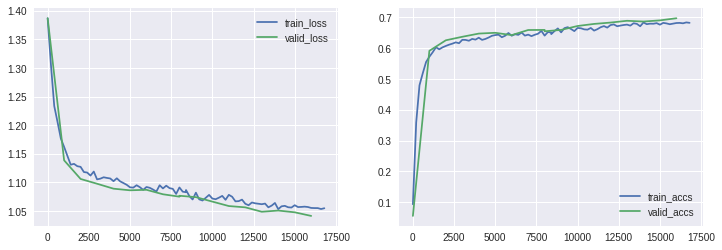

In [9]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()